In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
complete_df=pd.read_pickle(r'C:\Users\analy\Documents\Instacart Basket Analysis\02 Data\Manipulated\complete_3_df.pkl')

PII: customers names connected to personal data like family staues, gender, age and income are included. this should be noted to the supervisor before proceeding.

#### Creating Region column

In [3]:
# Define regions as lists (cleaner style)
northeast = [
    "Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut",
    "New York", "Pennsylvania", "New Jersey"
]

midwest = [
    "Wisconsin", "Michigan", "Illinois", "Indiana", "Ohio",
    "North Dakota", "South Dakota", "Nebraska", "Kansas",
    "Minnesota", "Iowa", "Missouri"
]

south = [
    "Delaware", "Maryland", "District of Columbia", "Virginia", "West Virginia",
    "North Carolina", "South Carolina", "Georgia", "Florida",
    "Kentucky", "Tennessee", "Mississippi", "Alabama",
    "Oklahoma", "Texas", "Arkansas", "Louisiana"
]

west = [
    "Idaho", "Montana", "Wyoming", "Nevada", "Utah", "Colorado",
    "Arizona", "New Mexico", "Alaska", "Washington", "Oregon",
    "California", "Hawaii"
]

# Build dictionary automatically from lists
region_map = {}
for state in northeast:
    region_map[state] = "Northeast"
for state in midwest:
    region_map[state] = "Midwest"
for state in south:
    region_map[state] = "South"
for state in west:
    region_map[state] = "West"

# One-liner assignment
complete_df["region"] = complete_df["STATE"].map(region_map).fillna("Unknown")


Note: my first choice to create region column was to create an array with the for-loop code. each will have the list of states. then i define the new column based on the array. but AI help showed me that creating dictionary togethe with for-loop code and lists is cleaner and more effiecient in the lookup process.

#### Customer Spending Habit by Region

In [ ]:
crosstab= pd.crosstab(complete_df['region'], complete_df['spending_flag'],dropna= False)

In [ ]:
crosstab.to_clipboard()

In [ ]:
# Create bar chart 
crosstab.plot(kind="bar", figsize=(10,6))

# Add labels and title
plt.title("Spending by Region")
plt.xlabel("State")
plt.ylabel("Spending")

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure at 300 dpi with tight bounding box
plt.savefig(
    r'C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\Visualization\Spending by region.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()


the south region has the highest high spenders and Northwest has the  lowes spenders.

#### Exclusion of less active customers

In [ ]:
# part1: creating low activity flag column for customers with less than 5 orders
complete_df.groupby('user_id') 
complete_df.loc[complete_df["order_number"] <= 5, "low_activity_flag"] = "less active"


In [ ]:
complete_df.head(20)

In [ ]:
# Create subset with only user_id and low_activity_flag
less_active_c = complete_df.loc[complete_df["low_activity_flag"] == "less active", 
                                ["user_id", "low_activity_flag"]]

In [ ]:
less_active_c.head()


In [ ]:
# Export to CSV
less_active_c.to_csv(r"C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\less_active_users.csv", index=False)


In [ ]:
# excluding the less active users from the dataframe
complete_df= complete_df[complete_df["low_activity_flag"] != "less active"]

subset of less active users were exported and excluded from the dataframe. although it was not worth it this work becaus eth esubset is only 5 rows of 1 user. this will not affect the analysis and statistics later.

#### Creating User_profie flag column 

In [4]:
# part 1: creating an array with all conditions (to stay clean and orgeniyed and more effiecient, better than multiple loc assignments)
conditions = [
    # Married + kids + high income
    (complete_df['fam_status'] == 'married') & (complete_df['n_kids'] >= 1) & (complete_df['income'] > 200000),
    
    # Married + kids + lower income
    (complete_df['fam_status'] == 'married') & (complete_df['n_kids'] >= 1) & (complete_df['income'] <= 200000),
    
    # Married + no kids + high income
    (complete_df['fam_status'] == 'married') & (complete_df['n_kids'] == 0) & (complete_df['income'] > 200000),
    
    # Married + no kids + lower income
    (complete_df['fam_status'] == 'married') & (complete_df['n_kids'] == 0) & (complete_df['income'] <= 200000),
    
    # Single + age > 25
    (complete_df['fam_status'] == 'single') & (complete_df['Age'] > 25),
    
    # Single + age <= 25
    (complete_df['fam_status'] == 'single') & (complete_df['Age'] <= 25),
    
    # Divorced/Widowed + age >= 65
    (complete_df['fam_status'].isin(['divorced', 'widowed'])) & (complete_df['Age'] >= 65),
    
    # Divorced/Widowed + income >= 400000
    (complete_df['fam_status'].isin(['divorced', 'widowed'])) & (complete_df['income'] >= 400000),
    # Single + income >= 400000
    (complete_df['fam_status'].isin(['single'])) & (complete_df['income'] >= 400000)
]

choices = [
    'Rich Parent',
    'Regular Parent',
    'Rich Pair',
    'Regular Pair',
    'midage Single',
    'Young Single',
    'Single Old',
    'Rich old singles',
    'Rich singles'
]
# creating the new columns based on the array
complete_df['user_profile'] = np.select(conditions, choices, default='Other')


In [ ]:
# Part 2: creating crosstab of user profile vs. department id to have a look at the differences in the goods type betwen user profiles
dep_profile_cr= pd.crosstab(complete_df['user_profile'], complete_df['department_id'])

In [ ]:
dep_profile_cr

In [ ]:
plt.figure(figsize=(18, 6))  # wide enough for 21 departments
sns.heatmap(
    dep_profile_cr.div(dep_profile_cr.sum(axis=1), axis=0), 
    cmap="coolwarm"
)

plt.title("User Profile Distribution Across Departments")
plt.xlabel("Department ID")
plt.ylabel("User Profile")
plt.xticks(rotation=45)  # rotate department labels for readability
plt.savefig(
    r'C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\Visualization\department products by user profile.png',
    dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
# transpose so departments are rows (y-axis)
dep_profile_cr_T = dep_profile_cr.T  

plt.figure(figsize=(12, 12))  # taller figure since 21 departments on y-axis
sns.heatmap(
    dep_profile_cr_T, 
    cmap="coolwarm", 
    annot=False, 
    cbar=True
)

plt.title("Department vs User Profile Heatmap")
plt.xlabel("User Profile")
plt.ylabel("Department ID")
plt.yticks(rotation=0)   # keep department labels horizontal for readability

plt.tight_layout()
plt.savefig(
    r'C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\Visualization\department_vs_user_profile_raw.png',
    dpi=300
)
plt.show()


The heatmap of department id counts for each user profile shows that the regular parants has a different list of goods than other profiles. 

#### frequency and expendeture statistics for user profile

In [15]:
ordering_freq_profile = (
    complete_df
    .groupby('user_profile')
    .agg(
        min_days_since_prior_order=('days_since_prior_order', 'min'),
        max_days_since_prior_order=('days_since_prior_order', 'max'),
        mean_days_since_prior_order=('days_since_prior_order', 'mean'),
        expenditure=('mean_order', 'mean') 
    )
)


In [12]:
ordering_freq_profile

,user_profile,min_days_since_prior_order,max_days_since_prior_order,mean_days_since_prior_order,expenditure
0,Other,0.0,30.0,11.047920,17.283226
1,Regular Parent,0.0,30.0,11.123184,17.069741
2,Rich Parent,0.0,30.0,10.292140,19.305399
3,Young Single,0.0,30.0,11.242402,16.948375
4,midage Single,0.0,30.0,11.064759,17.330305


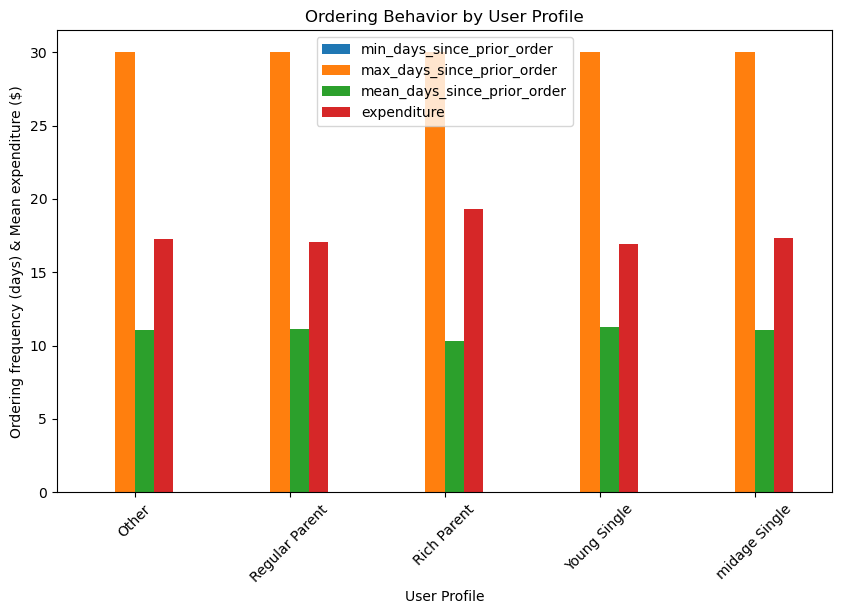

In [17]:
import matplotlib.pyplot as plt

# Create Bar plot
ordering_freq_profile.plot(kind='bar', figsize=(10,6))

# Add labels and title
plt.xlabel('User Profile')
plt.ylabel('Ordering frequency (days) & Mean expenditure ($)')
plt.title('Ordering Behavior by User Profile')

# Save the plot before showing it
plt.savefig(
    r'C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\Visualization\ordering_behavior_by_user_profile.png',
    dpi=300,
    bbox_inches='tight'
)
plt.xticks(rotation=45) 
# Show the plot
plt.show()


#### User Profiles by Region

In [5]:
# creating crosstab of user profile vs. region 
reg_profile_cr= pd.crosstab(complete_df['user_profile'], complete_df['region'])

In [ ]:
reg_profile_cr

In [ ]:
# user profile by region
plt.figure(figsize=(12, 12)) 
sns.heatmap(
    reg_profile_cr.div(reg_profile_cr.sum(axis=1), axis=0), 
    cmap="coolwarm"
)

plt.title("User Profile Distribution Across Regions")
plt.xlabel("Region")
plt.ylabel("User Profile")
plt.xticks(rotation=45)  # rotate Region labels for readability
plt.savefig(
    r'C:\Users\analy\Documents\Instacart Basket Analysis\04 Analysis\Visualization\user profile by region.png',
    dpi=300)
plt.tight_layout()
plt.show()


user profiles are highly concentrated in the south region mainly the young Singles (below age 25). wihle Northeast with the lowest population.

In [18]:
complete_df.to_pickle(r'C:\Users\analy\Documents\Instacart Basket Analysis\02 Data\Manipulated\complete_3_df.pkl')